In [64]:
import pandas as pd
import os
import re
import sys
from pyspark.sql import SparkSession
import gzip

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [65]:
spark = SparkSession.builder \
    .appName("MyApp") \
    .getOrCreate()

sc = spark.sparkContext

In [66]:
def combine_log_files(file1, file2, output_file):
    with open(output_file, 'wb') as outfile:
        for filename in [file1, file2]:
            with open(filename, 'rb') as infile:
                outfile.write(infile.read())

In [67]:
# File names with .txt extension
july_log = "access_log_Jul95.txt"
august_log = "access_log_Aug95.txt"
combined_log = "access_log_JulAug_95.txt"

# Combine the files
combine_log_files(july_log, august_log, combined_log)

print(f"Files {july_log} and {august_log} have been combined into {combined_log}")

Files access_log_Jul95.txt and access_log_Aug95.txt have been combined into access_log_JulAug_95.txt


In [68]:
base_df = spark.read.text("access_log_JulAug_95.txt")
base_df.printSchema()

root
 |-- value: string (nullable = true)



In [69]:
base_df_rdd = base_df.rdd
type(base_df_rdd)

pyspark.rdd.RDD

In [70]:
sample_logs = [item['value'] for item in base_df.take(15)]

In [71]:
host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
hosts = [re.search(host_pattern, item).group(1)
           if re.search(host_pattern, item)
           else 'no match'
           for item in sample_logs]


In [72]:
ts_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]'
timestamps = [re.search(ts_pattern, item).group(1) for item in sample_logs]

In [73]:
method_uri_protocol_pattern = r'\"(\S+)\s(\S+)\s*(\S*)\"'
method_uri_protocol = [re.search(method_uri_protocol_pattern, item).groups()
               if re.search(method_uri_protocol_pattern, item)
               else 'no match'
              for item in sample_logs]

In [74]:
status_pattern = r'\s(\d{3})\s'
status = [re.search(status_pattern, item).group(1) for item in sample_logs]

In [75]:
content_size_pattern = r'\s(\d+)$'
content_size = [re.search(content_size_pattern, item).group(1) for item in sample_logs]

In [76]:
from pyspark.sql.functions import regexp_extract

logs_df = base_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                         regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                         regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                         regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                         regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                         regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                         regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
logs_df.show(10, truncate=True)
print((logs_df.count(), len(logs_df.columns)))

+--------------------+--------------------+------+--------------------+--------+------+------------+
|                host|           timestamp|method|            endpoint|protocol|status|content_size|
+--------------------+--------------------+------+--------------------+--------+------+------------+
|        199.72.81.55|01/Jul/1995:00:00...|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|
|unicomp6.unicomp.net|01/Jul/1995:00:00...|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   200|    

In [77]:
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as spark_sum
def count_null(col_name):
    return spark_sum(col(col_name).isNull().cast('integer')).alias(col_name)
# Build up a list of column expressions, one per column.
exprs = [count_null(col_name) for col_name in logs_df.columns]

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|       33904|
+----+---------+------+--------+--------+------+------------+



In [78]:
logs_df = logs_df.na.fill({'content_size':0})
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+



In [79]:
from pyspark.sql.functions import udf

month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(text):
    """ Convert Common Log time format into a Python datetime object
    Args:
        text (str): date and time in Apache time format [dd/mmm/yyyy:hh:mm:ss (+/-)zzzz]
    Returns:
        a string suitable for passing to CAST('timestamp')
    """
    # NOTE: We're ignoring the time zones here, might need to be handled depending on the problem you are solving
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(text[7:11]),
      month_map[text[3:6]],
      int(text[0:2]),
      int(text[12:14]),
      int(text[15:17]),
      int(text[18:20]))

In [80]:
sample_ts = [item['timestamp'] for item in logs_df.select('timestamp').take(5)]
sample_ts

['01/Jul/1995:00:00:01 -0400',
 '01/Jul/1995:00:00:06 -0400',
 '01/Jul/1995:00:00:09 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:11 -0400']

In [81]:
[parse_clf_time(item) for item in sample_ts]

['1995-07-01 00:00:01',
 '1995-07-01 00:00:06',
 '1995-07-01 00:00:09',
 '1995-07-01 00:00:11',
 '1995-07-01 00:00:11']

In [82]:
udf_parse_time = udf(parse_clf_time)

logs_df = logs_df.select('*', udf_parse_time(logs_df['timestamp']).cast('timestamp').alias('time')).drop('timestamp')
logs_df.show(10, truncate=True)

+--------------------+------+--------------------+--------+------+------------+-------------------+
|                host|method|            endpoint|protocol|status|content_size|               time|
+--------------------+------+--------------------+--------+------+------------+-------------------+
|        199.72.81.55|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|1995-07-01 00:00:01|
|unicomp6.unicomp.net|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|1995-07-01 00:00:06|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|1995-07-01 00:00:09|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|1995-07-01 00:00:11|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|1995-07-01 00:00:11|
|  burger.letters.com|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|1995-07-01 00:00:12|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   200|           0|1995-07-01 00:00:12|


In [83]:
logs_df.cache()

DataFrame[host: string, method: string, endpoint: string, protocol: string, status: int, content_size: int, time: timestamp]

### Part 1

#### Status code distribution by session of the day


In [84]:
from pyspark.sql import functions as F

# Convert timestamp to datetime and truncate to hour
df = logs_df.withColumn('date_hour', F.date_trunc('hour', F.col('time')))


In [85]:
# 1. Total Requests Over Time (by hour)
traffic_trends = df.groupBy('date_hour').count().orderBy('date_hour')

# 2. Status Code Distribution Over Time (by hour)
status_distribution = df.groupBy('date_hour', 'status').count().orderBy('date_hour', 'status')

# Convert to Pandas for plotting
traffic_trends_pd = traffic_trends.toPandas()
status_distribution_pd = status_distribution.toPandas()

# Pivot for stacked area or bar chart plotting
status_pivot = status_distribution_pd.pivot(index='date_hour', columns='status', values='count').fillna(0)


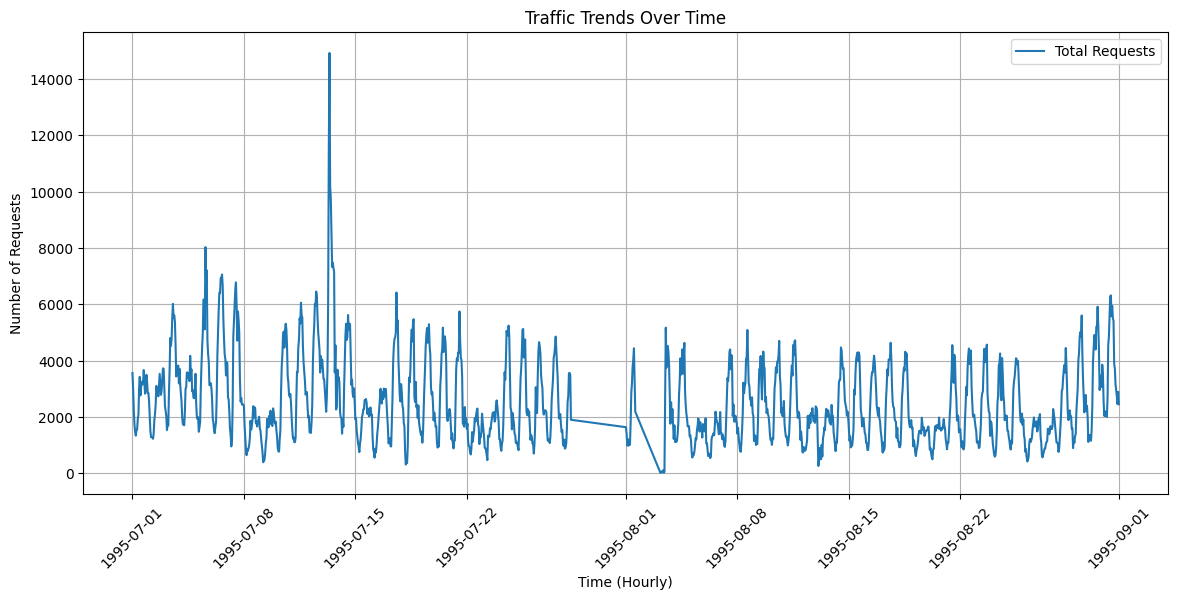

In [86]:
import matplotlib.pyplot as plt

# Plot total requests over time
plt.figure(figsize=(14, 6))
plt.plot(traffic_trends_pd['date_hour'], traffic_trends_pd['count'], label='Total Requests')
plt.title("Traffic Trends Over Time")
plt.xlabel("Time (Hourly)")
plt.ylabel("Number of Requests")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()


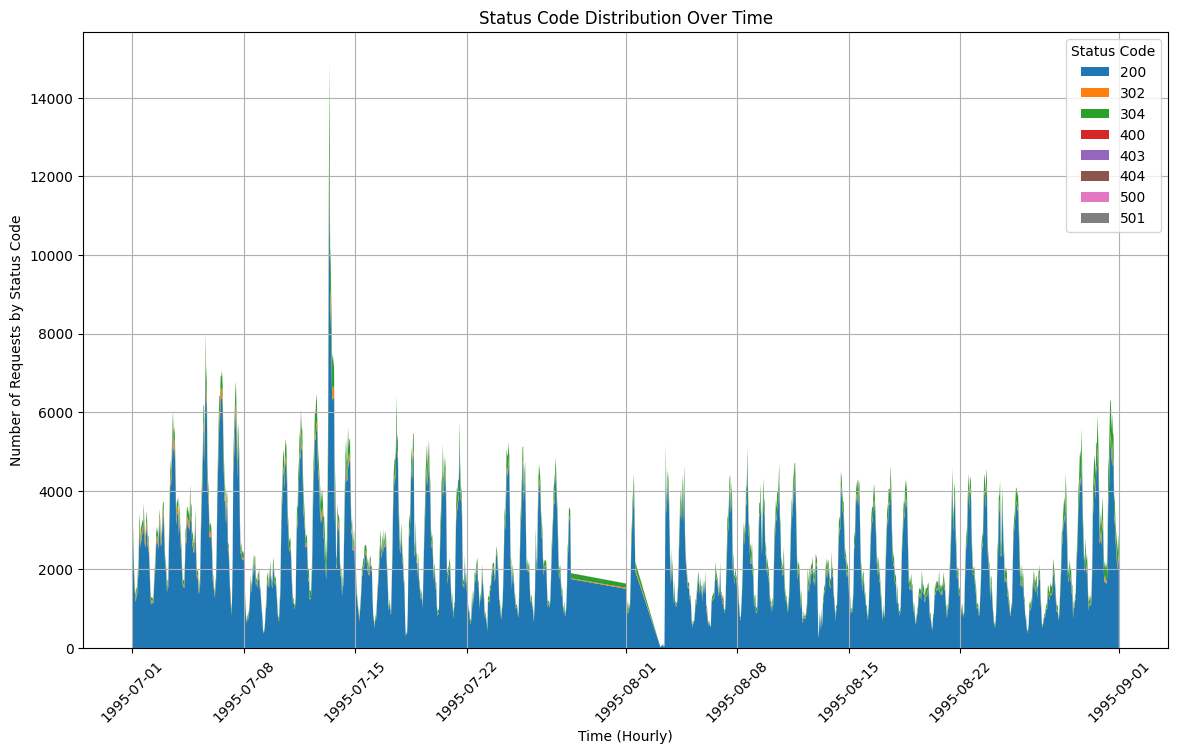

In [87]:
# Stacked Area Chart for status code distribution
plt.figure(figsize=(14, 8))
plt.stackplot(status_pivot.index, status_pivot.T, labels=status_pivot.columns)
plt.title("Status Code Distribution Over Time")
plt.xlabel("Time (Hourly)")
plt.ylabel("Number of Requests by Status Code")
plt.legend(title="Status Code")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [88]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

# Define a function to categorize the session of the day based on the hour
def get_session(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

# Register the function as a UDF in PySpark
get_session_udf = F.udf(lambda x: get_session(x), StringType())

# Extract the hour from the timestamp and add a 'session' column
df = df.withColumn('hour', F.hour('time'))
df = df.withColumn('session', get_session_udf(df['hour']))


In [89]:
# Aggregate counts by session and status code
session_distribution = df.groupBy('session', 'status').count().orderBy('session', 'status')

# Convert to Pandas for easier plotting
session_distribution_pd = session_distribution.toPandas()

# Pivot the DataFrame for a stacked bar chart
session_pivot = session_distribution_pd.pivot(index='session', columns='status', values='count').fillna(0)

# Sort sessions for logical order
session_order = ['Morning', 'Afternoon', 'Evening', 'Night']
session_pivot = session_pivot.reindex(session_order)


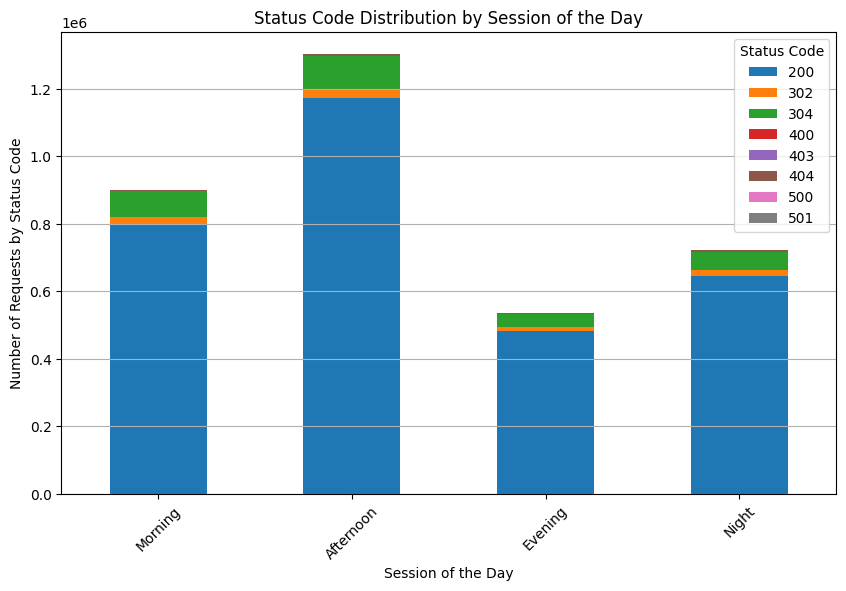

In [90]:
import matplotlib.pyplot as plt

# Plot the stacked bar chart for session-based status code distribution
session_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Status Code Distribution by Session of the Day")
plt.xlabel("Session of the Day")
plt.ylabel("Number of Requests by Status Code")
plt.legend(title="Status Code")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


#### Show the top 10 most requested endpoints

In [91]:
# Group by 'resource' to count the number of requests for each endpoint
top_endpoints = logs_df.groupBy('endpoint').count().orderBy(F.desc('count')).limit(10)

# Show the top 10 most requested endpoints
top_endpoints.show()


+--------------------+------+
|            endpoint| count|
+--------------------+------+
|/images/NASA-logo...|208714|
|/images/KSC-logos...|164970|
|/images/MOSAIC-lo...|127908|
|/images/USA-logos...|127074|
|/images/WORLD-log...|125925|
|/images/ksclogo-m...|121572|
|           /ksc.html| 83909|
|/images/launch-lo...| 76006|
|/history/apollo/i...| 68896|
| /shuttle/countdown/| 64736|
+--------------------+------+



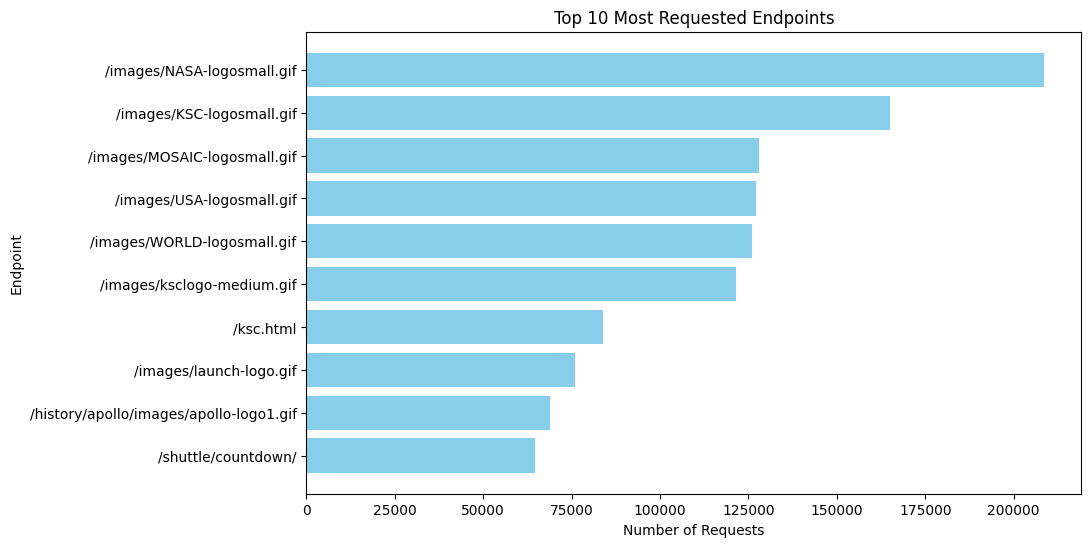

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert to Pandas for visualization
top_endpoints_pd = top_endpoints.toPandas()

# Plotting the Top 10 Most Requested Endpoints
plt.figure(figsize=(10, 6))
plt.barh(top_endpoints_pd['endpoint'], top_endpoints_pd['count'], color='skyblue')
plt.xlabel("Number of Requests")
plt.ylabel("Endpoint")
plt.title("Top 10 Most Requested Endpoints")
plt.gca().invert_yaxis()  # Invert y-axis for readability
plt.show()


#### Daily Request Volume Over Time


In [93]:
from pyspark.sql import functions as F

# Extract year and month, then format it as 'YYYY-MM' for grouping
df = logs_df.withColumn('year_month', F.date_format(F.col('time'), 'yyyy-MM'))


In [94]:
# Group by 'year_month' and count the number of requests
monthly_request_volume = df.groupBy('year_month').count().orderBy('year_month')

# Convert to Pandas for visualization
monthly_request_volume_pd = monthly_request_volume.toPandas()


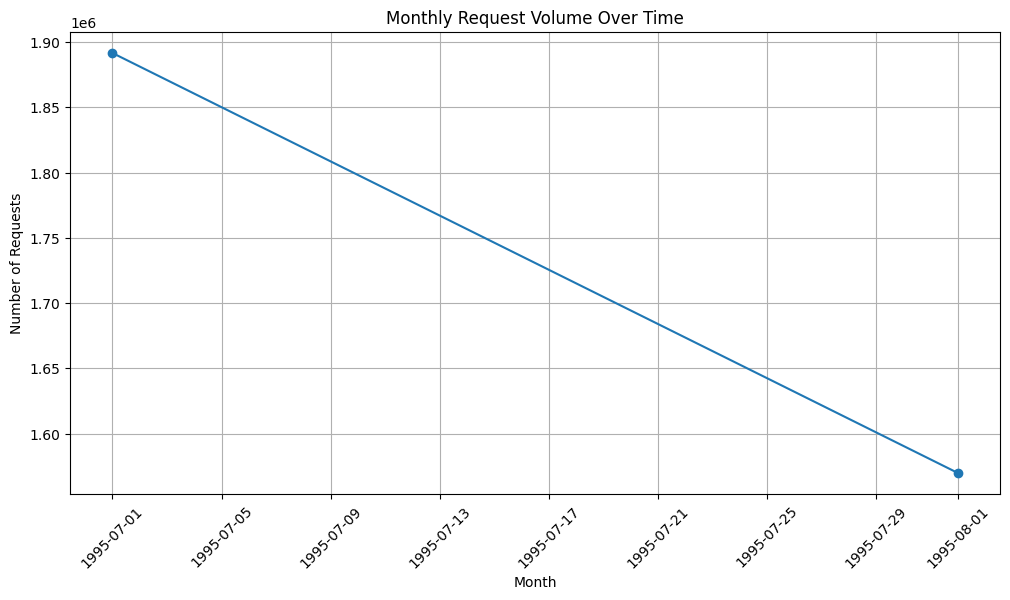

In [95]:
import matplotlib.pyplot as plt

# Convert the 'year_month' column to a datetime format for plotting
monthly_request_volume_pd['year_month'] = pd.to_datetime(monthly_request_volume_pd['year_month'])

# Plot the Monthly Request Volume Over Time
plt.figure(figsize=(12, 6))
plt.plot(monthly_request_volume_pd['year_month'], monthly_request_volume_pd['count'], marker='o', linestyle='-')
plt.title("Monthly Request Volume Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Requests")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


#### Host activity pattern through each period (user can interact by choosing time interval: daily, weekly)


In [96]:
import streamlit as st

# User selects time interval
time_interval = st.selectbox("Select Time Interval", options=["Daily", "Weekly"])


2024-11-19 11:33:12.670 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 11:33:12.672 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 11:33:12.674 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 11:33:12.676 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 11:33:12.682 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 11:33:12.683 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [97]:
from pyspark.sql import functions as F

# Add a 'date' and 'week' column for daily and weekly aggregation
df = df.withColumn('date', F.to_date('time'))
df = df.withColumn('week', F.date_trunc('week', 'time'))

# Choose aggregation based on user-selected interval
if time_interval == "Daily":
    host_activity = df.groupBy('date', 'host').count().orderBy('date', 'host')
else:  # Weekly
    host_activity = df.groupBy('week', 'host').count().orderBy('week', 'host')

# Convert to Pandas for plotting
host_activity_pd = host_activity.toPandas()


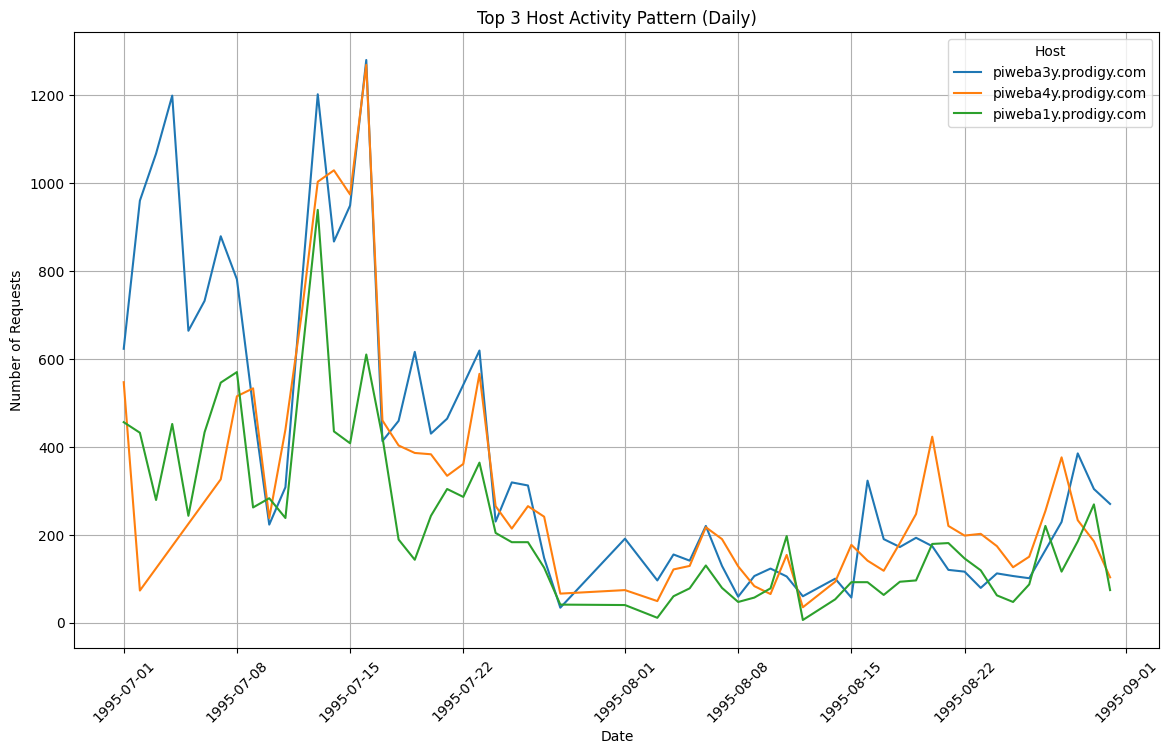

In [98]:
# Select top 3 hosts by activity for line chart (adjust as needed)
top_hosts = host_activity_pd.groupby('host')['count'].sum().nlargest(3).index
top_hosts_data = host_activity_pd[host_activity_pd['host'].isin(top_hosts)]

# Plot each host's activity over time
plt.figure(figsize=(14, 8))
for host in top_hosts:
    host_data = top_hosts_data[top_hosts_data['host'] == host]
    plt.plot(host_data['date' if time_interval == "Daily" else 'week'], host_data['count'], label=host)

plt.title(f"Top 3 Host Activity Pattern ({time_interval})")
plt.xlabel("Date" if time_interval == "Daily" else "Week")
plt.ylabel("Number of Requests")
plt.legend(title="Host")
plt.xticks(rotation=45)
plt.grid()
plt.show()


### Part 2

#### Top endpoints with high error rates over time

In [99]:
import streamlit as st

# User selects time interval
time_interval = st.selectbox("Select Time Interval", options=["Daily", "Hourly"])


2024-11-19 11:33:17.758 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 11:33:17.759 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 11:33:17.760 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 11:33:17.760 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 11:33:17.761 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 11:33:17.763 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [100]:
# Filter for error status codes (4XX and 5XX)
error_df = logs_df.filter((F.col('status') >= 400) & (F.col('status') < 600))


In [101]:
from pyspark.sql import functions as F

# Add date or hour column based on user-selected interval
if time_interval == "Daily":
    error_df = error_df.withColumn('date', F.to_date('time'))
else:  # Hourly
    error_df = error_df.withColumn('hour', F.date_trunc('hour', 'time'))


In [102]:
# Total requests by endpoint and interval
if time_interval == "Daily":
    total_requests = df.groupBy('endpoint', 'date').count().withColumnRenamed('count', 'total_requests')
else:
    total_requests = df.groupBy('endpoint', 'hour').count().withColumnRenamed('count', 'total_requests')

# Error requests by endpoint and interval
if time_interval == "Daily":
    error_requests = error_df.groupBy('endpoint', 'date').count().withColumnRenamed('count', 'error_count')
else:
    error_requests = error_df.groupBy('endpoint', 'hour').count().withColumnRenamed('count', 'error_count')


In [103]:
# Join total requests and error requests
error_rate_df = error_requests.join(total_requests, ['endpoint', 'date' if time_interval == "Daily" else 'hour'])

# Calculate error rate as a percentage
error_rate_df = error_rate_df.withColumn('error_rate', (F.col('error_count') / F.col('total_requests')) * 100)


In [104]:
# Sort by error rate in descending order and limit to top 10
top_error_endpoints = error_rate_df.orderBy(F.desc('error_rate')).limit(10)

# Convert to Pandas for visualization
top_error_endpoints_pd = top_error_endpoints.toPandas()


In [105]:
# Total requests by endpoint and interval (all requests)
if time_interval == "Daily":
    total_requests = df.groupBy('endpoint', 'date').count().withColumnRenamed('count', 'total_requests')
else:
    total_requests = df.groupBy('endpoint', 'hour').count().withColumnRenamed('count', 'total_requests')

# Error requests by endpoint and interval (only error requests)
if time_interval == "Daily":
    error_requests = error_df.groupBy('endpoint', 'date').count().withColumnRenamed('count', 'error_count')
else:
    error_requests = error_df.groupBy('endpoint', 'hour').count().withColumnRenamed('count', 'error_count')

# Perform a left join to ensure all total requests are included, even if there are no errors
error_rate_df = total_requests.join(error_requests, ['endpoint', 'date' if time_interval == "Daily" else 'hour'], "left").fillna(0)

# Calculate error rate as a percentage
error_rate_df = error_rate_df.withColumn('error_rate', (F.col('error_count') / F.col('total_requests')) * 100)


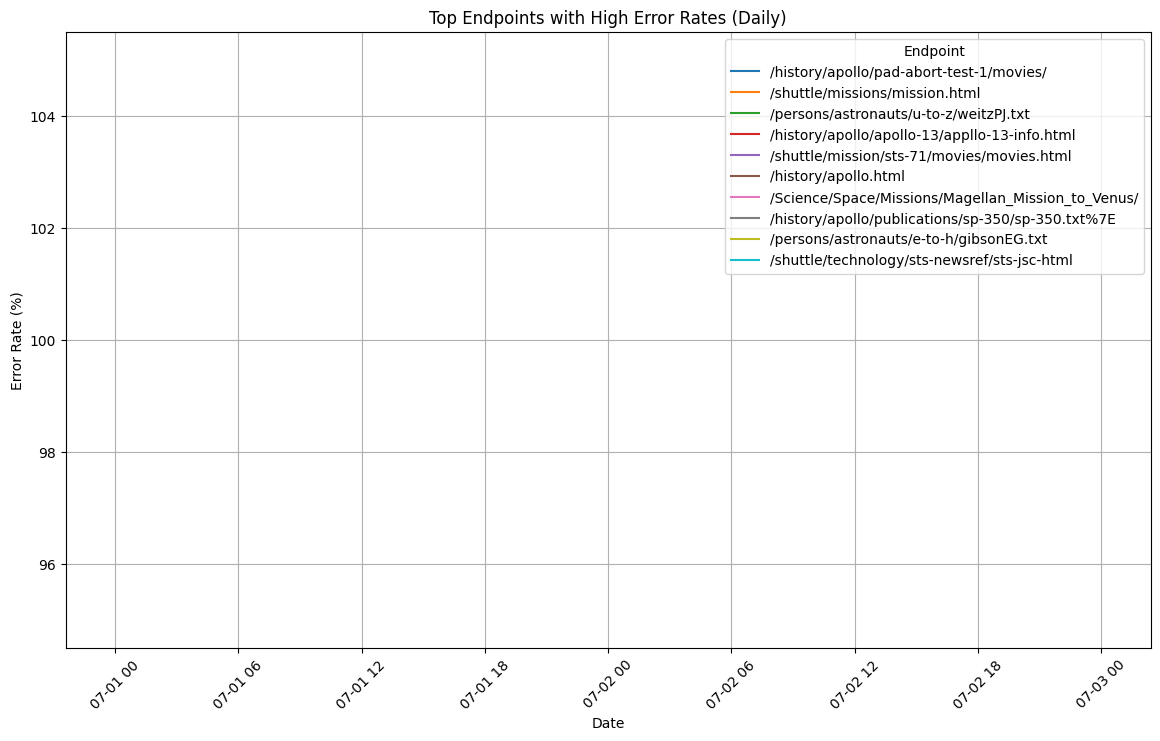

In [106]:
import matplotlib.pyplot as plt

# Plotting the Error Rates of Top Endpoints Over Time
plt.figure(figsize=(14, 8))
for endpoint in top_error_endpoints_pd['endpoint'].unique():
    endpoint_data = top_error_endpoints_pd[top_error_endpoints_pd['endpoint'] == endpoint]
    plt.plot(endpoint_data['date' if time_interval == "Daily" else 'hour'], endpoint_data['error_rate'], label=endpoint)

plt.title(f"Top Endpoints with High Error Rates ({time_interval})")
plt.xlabel("Date" if time_interval == "Daily" else "Hour")
plt.ylabel("Error Rate (%)")
plt.legend(title="Endpoint")
plt.xticks(rotation=45)
plt.grid()
plt.show()


In [107]:
from pyspark.sql import functions as F

# Extract endpoint using regex to find the path in the request section
log_df_parsed = logs_df.withColumn("endpoint", F.regexp_extract(F.col("endpoint"), r'"(?:GET|POST) ([^ ]+)', 1))


In [108]:
# Register as a temporary SQL view to run SQL queries
log_df_parsed.createOrReplaceTempView("logs")

# Run the query to get the top 10 most requested endpoints
top_endpoints = spark.sql("""
    SELECT endpoint, COUNT(*) AS request_count
    FROM logs
    GROUP BY endpoint
    ORDER BY request_count DESC
    LIMIT 10
""")

top_endpoints.show()


+--------+-------------+
|endpoint|request_count|
+--------+-------------+
|        |      3461612|
+--------+-------------+



#### Analyze traffic patterns for peak load times ( timestamp)- hourly


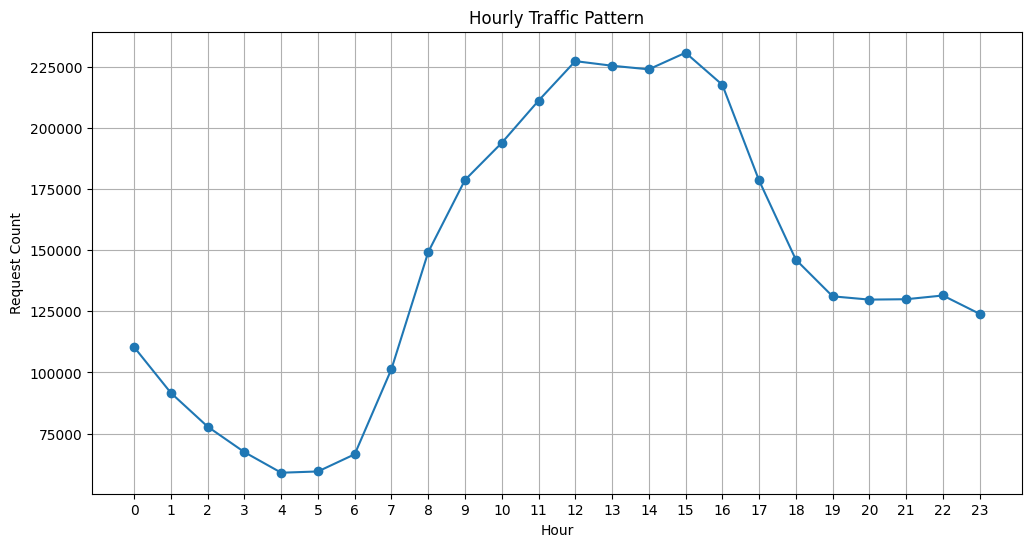

In [109]:
# Convert 'time' column to timestamp if it's in string format
logs_df = logs_df.withColumn("time", F.to_timestamp("time", "yyyy-MM-dd HH:mm:ss"))

# Drop rows where 'time' couldn't be converted (if any)
logs_df = logs_df.filter(logs_df['time'].isNotNull())

# Extract the hour from each timestamp
logs_df = logs_df.withColumn('hour', F.hour('time'))

# Optional: Filter to ensure only valid hour values (0 to 23)
logs_df = logs_df.filter((logs_df['hour'] >= 0) & (logs_df['hour'] < 24))

# Group by hour to count the number of requests for each hour
hourly_counts = logs_df.groupBy('hour').count().orderBy('hour')

# Convert to Pandas for plotting
hourly_counts_pd = hourly_counts.toPandas()

# Plot the hourly traffic pattern
plt.figure(figsize=(12, 6))
plt.plot(hourly_counts_pd['hour'], hourly_counts_pd['count'], marker='o')
plt.title("Hourly Traffic Pattern")
plt.xlabel("Hour")
plt.ylabel("Request Count")
plt.xticks(range(24))  # Ensure all 24 hours are represented
plt.grid()
plt.show()

#### Status Code Distribution by HTTP Method

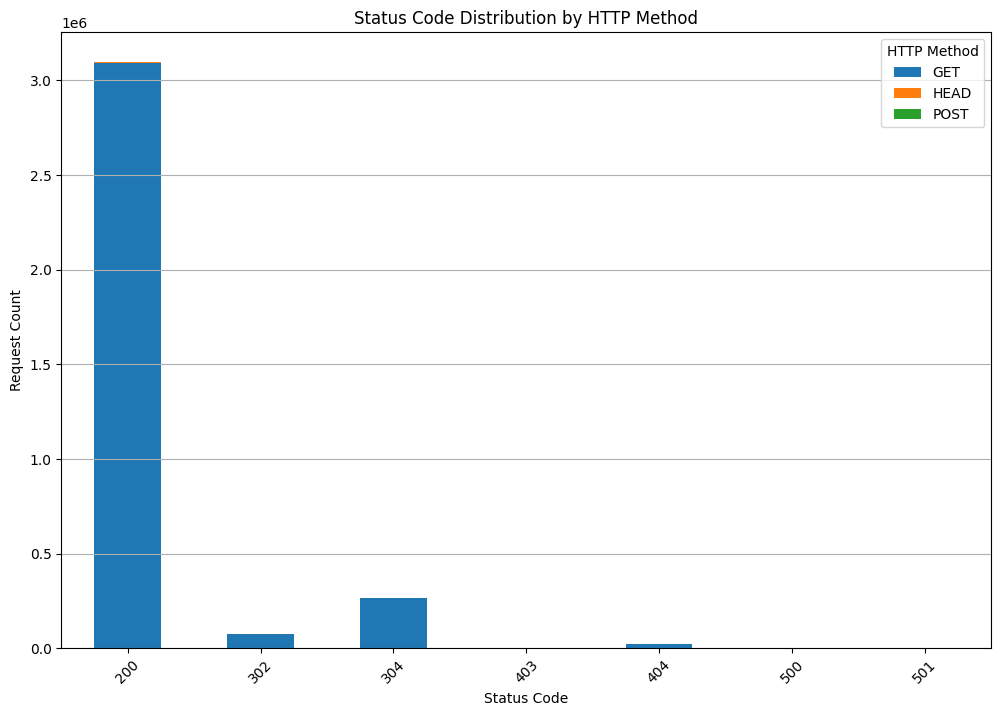

In [110]:
# Convert 'time' column to timestamp if it exists and is in string format
logs_df = logs_df.withColumn("time", F.to_timestamp("time", "yyyy-MM-dd HH:mm:ss"))

# Filter for the four HTTP methods only (GET, POST, PUT, DELETE)
logs_df = logs_df.filter(logs_df['method'].isin(['GET', 'POST', 'HEAD', ' ']))

# Group by 'method' and 'status', and count occurrences
status_distribution = logs_df.groupBy('method', 'status').count()

# Convert to Pandas DataFrame for easier plotting
status_distribution_pd = status_distribution.toPandas()

# Pivot the DataFrame to get methods as columns and status codes as rows for plotting
status_pivot = status_distribution_pd.pivot(index='status', columns='method', values='count').fillna(0)

# Sort status codes for logical ordering
status_pivot = status_pivot.sort_index()

# Plot as a stacked bar chart
status_pivot.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title("Status Code Distribution by HTTP Method")
plt.xlabel("Status Code")
plt.ylabel("Request Count")
plt.legend(title="HTTP Method")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()




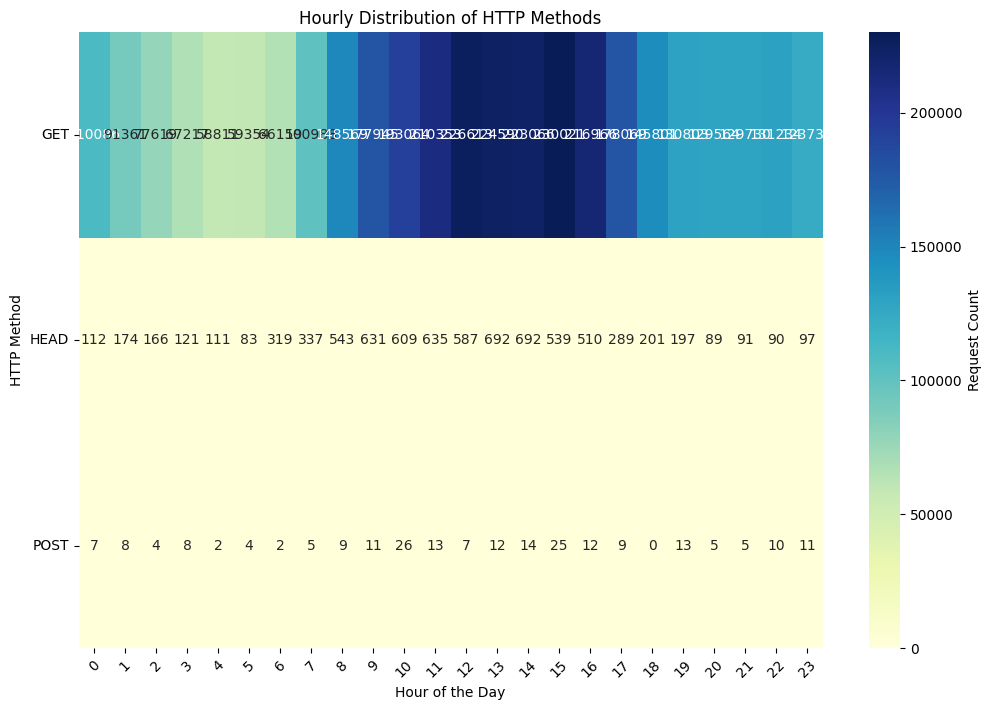

In [111]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark session
spark = SparkSession.builder.appName("HourlyMethodDistribution").getOrCreate()


# Convert 'timestamp' column to timestamp if it's in string format
logs_df = logs_df.withColumn("time", F.to_timestamp("time", "yyyy-MM-dd HH:mm:ss"))

# Extract the hour from each timestamp
logs_df = logs_df.withColumn('hour', F.hour('time'))

# Optional: Filter by specific status codes if needed, e.g., for 200 OK and 404 Not Found only
# logs_df = logs_df.filter(logs_df['status'].isin([200, 404]))

# Group by hour and HTTP method, count requests for each combination
hourly_method_counts = logs_df.groupBy('hour', 'method').count()

# Convert to Pandas DataFrame for plotting
hourly_method_counts_pd = hourly_method_counts.toPandas()

# Pivot the DataFrame to have hours on the x-axis, methods on the y-axis, and counts as values
heatmap_data = hourly_method_counts_pd.pivot(index='method', columns='hour', values='count').fillna(0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".0f", cbar_kws={'label': 'Request Count'})
plt.title("Hourly Distribution of HTTP Methods")
plt.xlabel("Hour of the Day")
plt.ylabel("HTTP Method")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Stop Spark session
spark.stop()


### Identify hosts that made the most failed requests (HTTP 4xx and 5xx status codes).

In [121]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, round, sum, avg

def analyze_failed_requests(logs_df):
    """
    Analyze failed requests (HTTP 4xx and 5xx) from NASA log data
    
    Parameters:
    logs_df: Spark DataFrame with columns: host, method, endpoint, protocol, status, content_size, time
    
    Returns:
    Spark DataFrame with detailed failure analysis
    """
    # Filter for failed requests (4xx and 5xx status codes)
    # Make sure status is treated as string in comparison
    failed_requests = logs_df.filter(
        "status IN ('400', '401', '403', '404', '500', '501', '502', '503', '504')"
    )
    
    # Group by host and analyze failures
    failed_requests_analysis = failed_requests.groupBy("host") \
        .agg(
            count("*").alias("failed_requests_count")
        )
    
    # Get total requests per host
    total_requests_by_host = logs_df.groupBy("host") \
        .agg(count("*").alias("total_requests"))
    
    # Join and calculate failure rates
    complete_analysis = failed_requests_analysis.join(
        total_requests_by_host, 
        "host"
    ).withColumn(
        "failure_rate",
        round((col("failed_requests_count") / col("total_requests") * 100), 2)
    )
    
    # Order by number of failed requests
    final_analysis = complete_analysis.select(
        "host",
        "failed_requests_count",
        "total_requests",
        "failure_rate"
    ).orderBy(col("failed_requests_count").desc())
    
    return final_analysis

# Execute the analysis
results = analyze_failed_requests(logs_df)

# Show top 3 hosts with most failures
print("\nTop 3 Hosts with Most Failed Requests:")
results.show(3, truncate=False)

# Get some summary statistics
print("\nOverall Statistics:")
results.agg(
    count("host").alias("total_hosts_with_failures"),
    sum("failed_requests_count").alias("total_failed_requests"),
    round(avg("failure_rate"), 2).alias("average_failure_rate")
).show()

# Additional error code breakdown
print("\nBreakdown by Error Code:")
failed_requests = logs_df.filter(col("status").isin(["400", "403", "404", "500", "501"]))
failed_requests.groupBy("status") \
    .count() \
    .orderBy("status") \
    .show()


Top 3 Hosts with Most Failed Requests:
+----+---------------------+--------------+------------+
|host|failed_requests_count|total_requests|failure_rate|
+----+---------------------+--------------+------------+
+----+---------------------+--------------+------------+


Overall Statistics:
+-------------------------+---------------------+--------------------+
|total_hosts_with_failures|total_failed_requests|average_failure_rate|
+-------------------------+---------------------+--------------------+
|                        0|                 NULL|                NULL|
+-------------------------+---------------------+--------------------+


Breakdown by Error Code:
+------+-----+
|status|count|
+------+-----+
+------+-----+



In [122]:
from pyspark.sql.functions import col, count

# 1. First identify failed requests
def analyze_failed_requests_simple(logs_df):
    # Filter failed requests and count by host
    host_failures = logs_df.filter(
        (col("status") == "404") | 
        (col("status") == "403") | 
        (col("status") == "500") | 
        (col("status") == "501")
    ).groupBy("host").count()
    
    # Rename count column and sort
    result = host_failures.select(
        col("host"),
        col("count").alias("failed_requests")
    ).orderBy(col("failed_requests").desc())
    
    return result

# Run analysis
results = analyze_failed_requests_simple(logs_df)

# Show results
print("\nTop Hosts with Failed Requests:")
results.show(10)

# Show total failures
print("\nTotal Failed Requests:")
results.agg({"failed_requests": "sum"}).show()

# Show breakdown by status code for these hosts
print("\nFailure Types for Top Hosts:")
top_hosts = results.limit(5).select("host")
logs_df.join(top_hosts, "host") \
    .filter(col("status").isin(["404", "403", "500", "501"])) \
    .groupBy("host", "status") \
    .count() \
    .orderBy("host", "status") \
    .show()


Top Hosts with Failed Requests:
+----+---------------+
|host|failed_requests|
+----+---------------+
+----+---------------+


Total Failed Requests:
+--------------------+
|sum(failed_requests)|
+--------------------+
|                NULL|
+--------------------+


Failure Types for Top Hosts:
+----+------+-----+
|host|status|count|
+----+------+-----+
+----+------+-----+

